/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.3.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator VarianceThreshold from version 1.3.2 when using version 1.6.1. This might lead to breaking code or 

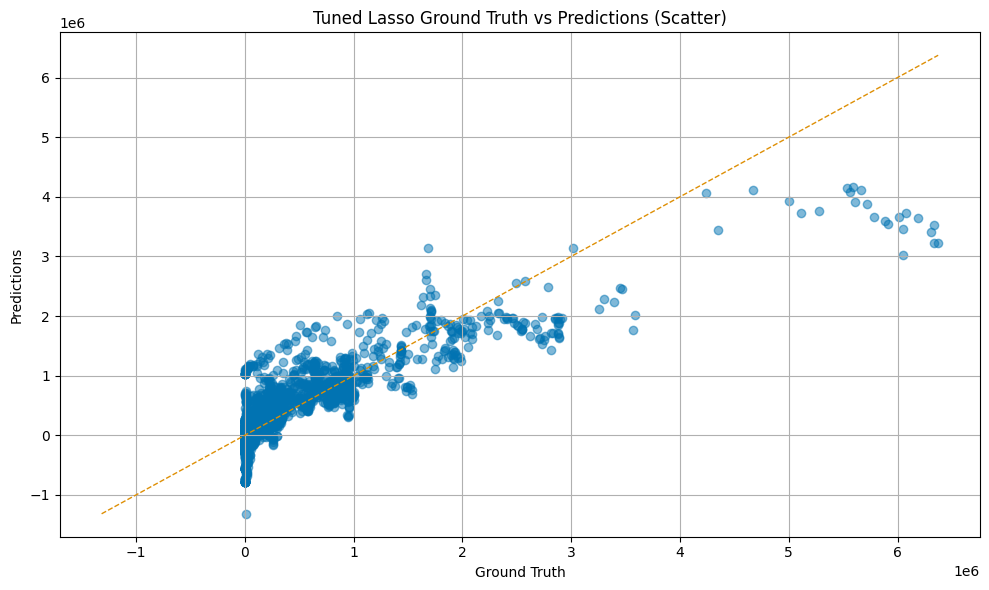

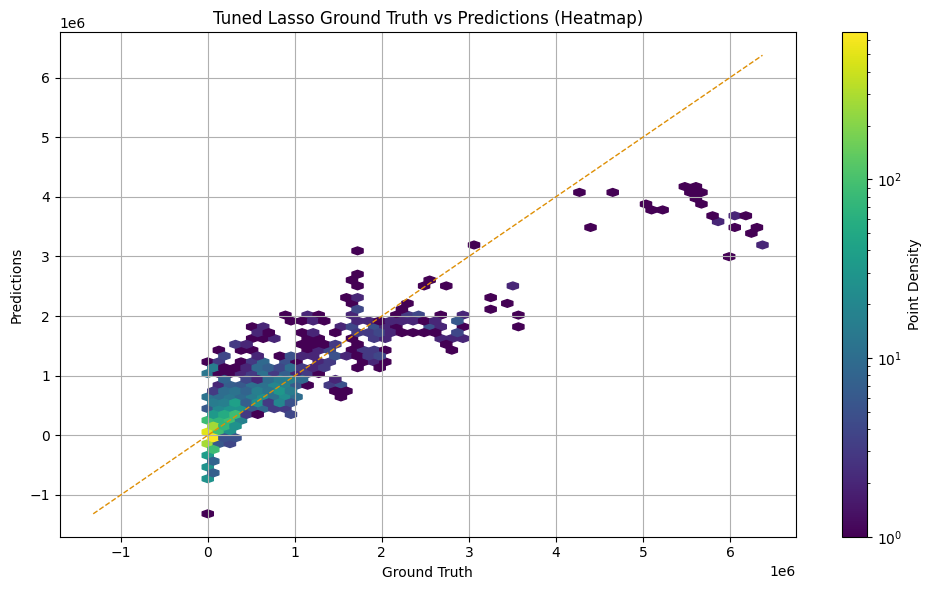

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

# Load Model
model = joblib.load('/content/trained_lasso_model.joblib')

# Feature Engineering
def feature_engineering(df):
    df_fe = df.copy()

    if 'daily_tests' in df_fe.columns and 'population' in df_fe.columns:
        df_fe['tests_per_capita'] = df_fe['daily_tests'] / (df_fe['population'] + 1e-5)

    if 'daily_positive_cases' in df_fe.columns and 'population' in df_fe.columns:
        df_fe['cases_per_capita'] = df_fe['daily_positive_cases'] / (df_fe['population'] + 1e-5)

    bed_cols = ['rural_beds', 'urban_beds', 'public_beds']
    existing_beds = [col for col in bed_cols if col in df_fe.columns]
    if existing_beds and 'population' in df_fe.columns:
        df_fe['total_beds'] = df_fe[existing_beds].sum(axis=1)
        df_fe['beds_per_1000'] = df_fe['total_beds'] / (df_fe['population'] / 1000 + 1e-5)

    if 'daily_positive_cases' in df_fe.columns and 'daily_tests' in df_fe.columns:
        df_fe['test_efficiency'] = df_fe['daily_positive_cases'] / (df_fe['daily_tests'] + 1e-5)

    if 'density' in df_fe.columns and 'Female to Male ratio' in df_fe.columns:
        df_fe['elderly_density'] = df_fe['density'] * df_fe['Female to Male ratio']

    return df_fe

# Correlation Removal
def remove_highly_correlated_features(df, target_col='cum_positive_cases',
                                      target_corr_threshold=0.85,
                                      feature_corr_threshold=0.8):

    df_clean = df.copy()
    drop_cols = ['dates', 'date','cum_tests']
    df_features = df_clean.drop(columns=[col for col in drop_cols if col in df_clean.columns], errors='ignore')
    numeric_df = df_features.select_dtypes(include=[np.number])

    if target_col in numeric_df.columns:
        corr_with_target = numeric_df.corr()[target_col].drop(target_col)
        to_drop_target = corr_with_target[abs(corr_with_target) > target_corr_threshold].index.tolist()
        df_clean.drop(columns=to_drop_target, inplace=True)

    numeric_df = df_clean.select_dtypes(include=[np.number])
    feature_cols = numeric_df.drop(columns=[target_col], errors='ignore')

    if len(feature_cols.columns) > 1:
        corr_matrix = feature_cols.corr().abs()
        upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
        to_drop_features = [
            col for col in upper_triangle.columns
            if any(upper_triangle[col] > feature_corr_threshold)
        ]
        df_clean.drop(columns=to_drop_features, inplace=True)

    return df_clean

# Select Top K Features
def select_top_k_features(X, y, k='all'):
    numeric_X = X.select_dtypes(include=[np.number])
    selector = SelectKBest(score_func=f_regression, k=k)
    X_new = selector.fit_transform(numeric_X, y)
    selected_features = numeric_X.columns[selector.get_support()]
    X_selected = pd.DataFrame(X_new, columns=selected_features, index=X.index)
    return X_selected, selected_features

# Prepare Training Data
def prepare_training_data(df, target_col='cum_positive_cases', k='all'):
    df = feature_engineering(df)
    df = remove_highly_correlated_features(df, target_col=target_col)
    X = df.drop(columns=[target_col])
    y = df[target_col]
    X_selected, selected_features = select_top_k_features(X, y, k=k)
    if 'state' in df.columns:
        X_selected['state'] = df['state']
    df_selected = X_selected.copy()
    df_selected[target_col] = y
    return X_selected, y, df_selected

#  Plot Function
def plot_predictions_vs_ground_truth(y_true, y_pred, save_path=None, title_prefix=""):
    df = pd.DataFrame({
        "ground_truth": y_true,
        "predictions": y_pred
    })

    palette = sns.color_palette("colorblind")
    plt.figure(figsize=(10, 6))
    plt.scatter(df["ground_truth"], df["predictions"], alpha=0.5, color=palette[0])
    min_val = min(df["ground_truth"].min(), df["predictions"].min())
    max_val = max(df["ground_truth"].max(), df["predictions"].max())
    plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")
    plt.title(f"{title_prefix} Ground Truth vs Predictions (Scatter)")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, "scatter_gt_vs_pred.png"))
    plt.show()

    plt.figure(figsize=(10, 6))
    hb = plt.hexbin(df["ground_truth"], df["predictions"], gridsize=50, cmap="viridis", bins='log')
    plt.colorbar(hb, label='Point Density')
    plt.plot([min_val, max_val], [min_val, max_val], color=palette[1], linestyle='--', linewidth=1)
    plt.xlabel("Ground Truth")
    plt.ylabel("Predictions")
    plt.title(f"{title_prefix} Ground Truth vs Predictions (Heatmap)")
    plt.grid(True)
    plt.tight_layout()
    if save_path:
        plt.savefig(os.path.join(save_path, "heatmap_gt_vs_pred.png"))
    plt.show()

# Run Everything
df = pd.read_csv('/content/update.csv')
X_selected, y, df_selected = prepare_training_data(df, target_col='cum_positive_cases', k='all')

X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)
y_pred = model.predict(X_test)
plot_predictions_vs_ground_truth(y_test, y_pred, title_prefix="Tuned Lasso")


Scatter Plot : Ground Truth vs Predictions
shows how close the model’s predictions are to the real COVID-19 case numbers. If the model was perfect, all points would fall on the dashed line. Most points follow the general trend, but some are far from the line, especially when case numbers are high. This means the model does okay overall but sometimes misses on very high values.

Heatmap
shows where the model made most of its predictions. For very high case counts, predictions are more spread out and less accurate — the model underestimates these cases.

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"MAE: {mae:,.2f}")
print(f"R^2: {r2:.4f}")


RMSE: 326,762.98
MAE: 180,699.74
R^2: 0.7602


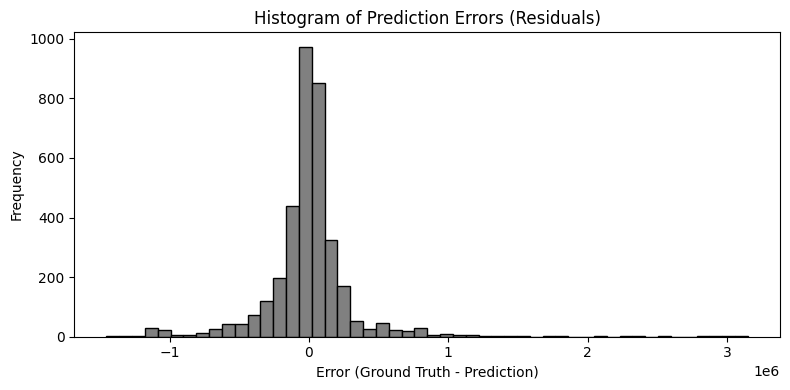

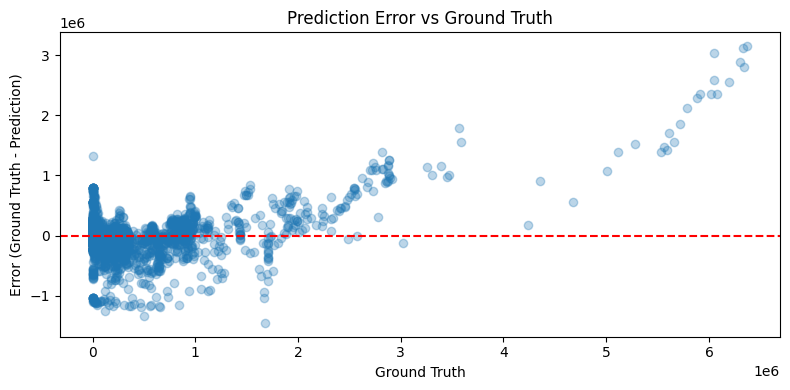

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrame
df = pd.DataFrame({
    "ground_truth": y_test,
    "predictions": y_pred
})

# Calculate errors (residuals)
errors = df["ground_truth"] - df["predictions"]

# Plot histogram of errors
plt.figure(figsize=(8, 4))
plt.hist(errors, bins=50, color='gray', edgecolor='black')
plt.title("Histogram of Prediction Errors (Residuals)")
plt.xlabel("Error (Ground Truth - Prediction)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot errors vs ground truth
plt.figure(figsize=(8, 4))
plt.scatter(df["ground_truth"], errors, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Prediction Error vs Ground Truth")
plt.xlabel("Ground Truth")
plt.ylabel("Error (Ground Truth - Prediction)")
plt.tight_layout()
plt.show()


Histogram of Errors
shows how much the model’s predictions were off. Most of the bars are near zero, which means the model usually guessed close to the real number. But there are some predictions that were too high or too low.

Errors vs Real Numbers
shows the size of the mistake for each real value. If the dots are above the red line, the model predicted too low. If they’re below the line, it predicted too high. For small numbers, the model is mostly accurate. For big numbers, it sometimes misses by a lot.